In [6]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation
import imageio.v2 as imageio

In [7]:
class Sender:
        
    def __init__(self, inputs_n: int, messages_n_m: (int, int), eps: float = 1e-6):
        self.messages = messages_n_m
        self.message_weights = (np.zeros((inputs_n, messages_n_m[0])), np.zeros((inputs_n, messages_n_m[1])))
        self.message_weights[0].fill(eps)
        self.message_weights[1].fill(eps)
        self.channel_weights = np.zeros(2, dtype=np.float128)
        self.channel_weights.fill(np.float128(eps))
        self.last_situation = (0, 0, (0, 0)) # urn, input, message, 
        
    def send_message(self, input: int) -> (int, int):
        # get a channel to manipulate
        channel_probs = np.array(list(map(float, np.exp(self.channel_weights)/np.sum(np.exp(self.channel_weights)))))
        channel = np.random.choice([0, 1], p=channel_probs)
        
        if channel == 0:
            # manipulate channel 0, the other is picked at random
            probs = np.exp(self.message_weights[0][input, :])/np.sum(np.exp(self.message_weights[0][input, :]))
            # channels = 2
            # probs = [0.2, 0.8]
            # channel[0] = self.messages[0] = [0, 1]
            # channel[1] = self.messages[1] = [0, 1, 2]
            # choise([0, 1], [0.2, 0.8])
            # choise([0, 1, 2], [0.333, 0.333, 0.333])
            # message = (1, 0)
            message = (np.random.choice(self.messages[0], p=probs), np.random.choice(self.messages[1]))
        else:
            # manipulate channel 0, the other is picked at random
            probs = np.exp(self.message_weights[1][input, :])/np.sum(np.exp(self.message_weights[1][input, :]))
            message = (np.random.choice(self.messages[0]), np.random.choice(self.messages[1], p=probs))
       
        self.last_situation = (channel, input, message)
        return message

    def learn_from_feedback(self, reward: float) -> None:
        self.channel_weights[self.last_situation[0]] += np.float128(reward)/10
        if self.last_situation[0] == 0:
            self.message_weights[0][(self.last_situation[1], self.last_situation[2][0])] += np.float128(reward)
        else:
            self.message_weights[1][(self.last_situation[1], self.last_situation[2][1])] += np.float128(reward)

In [17]:
class Receiver:
        
    def __init__(self, n_messages: int, m_messages: int, n_actions: int, eps: float = 1e-6):
        self.n_actions = n_actions
        self.action_weights = (np.ndarray((n_messages, n_actions)), np.ndarray((m_messages, n_actions)))
        #self.action_weights = np.ndarray((m_messages, n_actions))
        self.channel_weights  = np.zeros(2, dtype=np.float128)
        self.action_weights[0].fill(eps)
        self.action_weights[0].fill(eps)
        self.channel_weights.fill(np.float128(eps))
        self.last_situation = (0, (0, 0), 0)
        
    def act(self, message: (int, int)) -> int:
        # get channel to pay attention to
        channel_probs = np.array(list(map(float, np.exp(self.channel_weights)/np.sum(np.exp(self.channel_weights)))))
        channel = np.random.choice([0, 1], p=channel_probs)

        # pick action from focused channel
        if channel == 0:
            probs = np.exp(self.action_weights[0][message[0], :])/np.sum(np.exp(self.action_weights[0][message[0], :]))
            action = np.random.choice(self.n_actions, p=probs)
        else:
            probs = np.exp(self.action_weights[1][message[1], :])/np.sum(np.exp(self.action_weights[1][message[1], :]))
            #print(message[1])
            #print(probs)
            action = np.random.choice(self.n_actions, p=probs)
        self.last_situation = (channel, message, action)
        return action

    def learn_from_feedback(self, reward: float) -> None:
        self.channel_weights[self.last_situation[0]] += np.float128(reward)/10
        #print(self.last_situation[0], reward, self.channel_weights)
        if self.last_situation[0] == 0:
            self.action_weights[0][(self.last_situation[1][0], self.last_situation[2])] += reward
        else:
            self.action_weights[1][(self.last_situation[1][1], self.last_situation[2])] += reward

In [18]:
class World:
    def __init__(self, n_states: int, seed: int = 1701):
        self.n_states = n_states
        self.state = 0
        self.rng = np.random.RandomState(seed)
        
    def emit_state(self) -> int:
        self.state = self.rng.randint(self.n_states)
        return self.state
    
    def evaluate_action(self, action: int) -> float:
        return 1 if action == self.state else 0

In [21]:
class Run:
    def __init__(self):
        self.generations = 3000
        self.sender_convergence = []
        self.receiver_convergence = []
        self.num_inputs = 10
        self.channel_0 = 10
        self.channel_1 = 9
        self.sender = Sender(self.num_inputs, (self.channel_0, self.channel_1))
        self.receiver = Receiver(self.channel_0, self.channel_1, self.num_inputs)
        self.world = World(10)
        
    def simulate(self):
        for epoch in range(self.generations):
            world_state = self.world.emit_state()
            message = self.sender.send_message(world_state)
            action = self.receiver.act(message)
            reward = self.world.evaluate_action(action)
            self.receiver.learn_from_feedback(reward)
            self.sender.learn_from_feedback(reward)
            self.sender_convergence.append(self.sender.channel_weights[0]/np.sum(self.sender.channel_weights))
            self.receiver_convergence.append(self.receiver.channel_weights[0]/np.sum(self.receiver.channel_weights))
    
    def plot(self):
        t = np.arange(0, self.generations)
        fig, axs = plt.subplots(2, 1, layout='constrained')
        axs[0].plot(t, self.sender_convergence)
        axs[1].plot(t, self.receiver_convergence)
        #axs[0].set_ylim(0, 1)
        axs[0].set_xlabel('Generations')
        axs[1].set_xlabel('Generations')
        axs[0].set_ylabel('sender convergence')
        axs[1].set_ylabel('receiver convergence')
        axs[0].grid(True)
        axs[1].grid(True)
        
        plt.show()
        

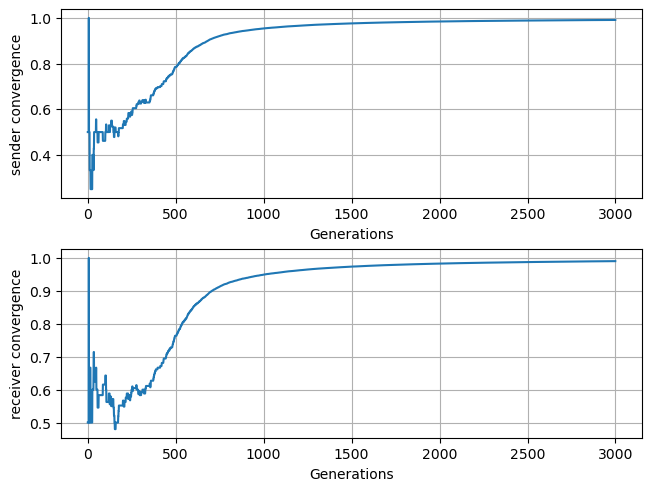

In [23]:
run = Run()
run.simulate()
run.plot()

In [24]:
sender_optimum = 0
receiver_optimum = 0
converge = 0
for i in range(100):
    if i % 10 == 0:
        print(i)
    run = Run()
    run.simulate()
    #run.plot()
    run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_sender_optimum = run.sender.channel_weights[0] > run.sender.channel_weights[1]
    is_receiver_optimum = run.receiver.channel_weights[0] > run.receiver.channel_weights[1]
    if is_sender_optimum:
        sender_optimum += 1
    if is_receiver_optimum:
        receiver_optimum += 1
    if (is_sender_optimum and is_receiver_optimum) or ((not is_sender_optimum) and (not is_receiver_optimum)):
        converge += 1
        
print("sender ends up in optimum", sender_optimum)
print("receiver ends up in optimum", receiver_optimum)
print("both converge", converge)

0
10
20
30
40
50
60
70
80
90
sender ends up in optimum 37
receiver ends up in optimum 38
both converge 85



![](sender.gif)

![](receiver.gif)
